In [109]:
import pandas as pd
import numpy as np
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from autoPyTorch import AutoNetClassification
from sklearn.preprocessing import StandardScaler
import torch

import matplotlib.pyplot as plt
import seaborn as sns

path = "data/"
df_train = pd.read_csv(path+"train_preprocess_binarized_hotEncoded_lite.csv")
df_test = pd.read_csv(path+"test.csv")



In [110]:


# data and metric imports





In [111]:
y = df_train["Survived"]
del df_train["Survived"]

In [112]:
type(y_test)

torch.Tensor

In [113]:
type(y_train)

torch.Tensor

In [114]:
type(X_test)

torch.Tensor

In [115]:
type(X_train)

torch.Tensor

In [116]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size = 0.25, random_state = 42)




In [117]:


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_test.shape)
print(X_train.shape)

class BinaryClassification(torch.nn.Module):
    def __init__(self, input_dimension):
        super().__init__()
        self.linear = torch.nn.Linear(input_dimension, 1)

    def forward(self, input_dimension):
        return self.linear(input_dimension)
    



(25000, 10)
(75000, 10)


In [118]:
type(y_test)

pandas.core.series.Series

In [119]:
type(y_train)

pandas.core.series.Series

In [120]:
type(X_test)

numpy.ndarray

In [121]:
type(X_train)

numpy.ndarray

In [122]:
_, input_dimension = X_train.shape

model = torch.nn.Linear(input_dimension, 1)

"""train the model"""

def configure_loss_function(): 
    return torch.nn.BCEWithLogitsLoss()

def configure_optimizer(model):
    return torch.optim.Adam(model.parameters())

def full_gd(model, criterion, optimizer, X_train, y_train, n_epochs=200000):
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)

    for it in range(n_epochs): 
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    outputs_test = model(X_test)
    loss_test = criterion(outputs_test, y_test)

    train_losses[it] = loss.item()
    test_losses[it] = loss_test.item()

    if (it + 1) % 50 == 0:
        print(f'In this epoch {it+1}/{n_epochs}, Training loss: {loss.item():.4f}, Test loss: {loss_test.item():.4f}')

    return train_losses, test_losses



In [123]:
y_train = y_train.to_numpy()

In [124]:
y_test = y_test.to_numpy()

In [125]:
type(y_test)

numpy.ndarray

In [126]:
type(y_train)

numpy.ndarray

In [127]:
type(X_test)

numpy.ndarray

In [128]:
type(X_train)

numpy.ndarray

In this epoch 200000/200000, Training loss: 0.5041, Test loss: 0.5057


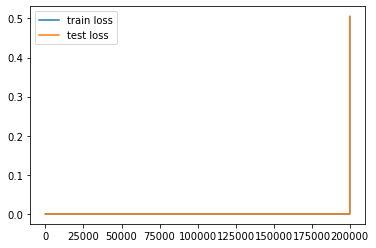

0.7668266666666667
0.76584


In [129]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32)).reshape(-1, 1)
y_test = torch.from_numpy(y_test.astype(np.float32)).reshape(-1, 1)

criterion = configure_loss_function()
optimizer = configure_optimizer(model)
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train)

plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

"""evaluate model"""

with torch.no_grad():
    p_train = model(X_train)
    p_train = (p_train.numpy() > 0)

    train_acc = np.mean(y_train.numpy() == p_train)

    p_test = model(X_test)
    p_test = (p_test.numpy() > 0)
  
    test_acc = np.mean(y_test.numpy() == p_test)

print(train_acc)
print(test_acc)

In [136]:
# banknote_bnn.py
# Banknote classification
# PyTorch 1.6.0-CPU Anaconda3-2020.02  Python 3.7.6
# Windows 10 

import numpy as np
import torch as T
device = T.device("cuda")  # apply to Tensor or Module

#        1         2         3         4         5         6
# 3456789012345678901234567890123456789012345678901234567890
# ----------------------------------------------------------
# predictors and label in same file
# archive.ics.uci.edu/ml/datasets/banknote+authentication
# IDs 0001 to 1372 added
# data has been k=20 normalized (all four columns)
# ID  variance  skewness  kurtosis  entropy  class
# [0]    [1]      [2]       [3]       [4]     [5]
#  (0 = authentic, 1 = forgery)  # verified
# train: 1097 items (80%), test: 275 item (20%)

# ---------------------------------------------------------

def accuracy(model, ds):
    # ds is a iterable Dataset of Tensors
    n_correct = 0; n_wrong = 0

    # alt: create DataLoader and then enumerate it
    for i in range(len(ds)):
        inpts = ds[i]['predictors']
        target = ds[i]['target']    # float32  [0.0] or [1.0]
        with T.no_grad():
            oupt = model(inpts)

        # avoid 'target == 1.0'
        if target < 0.5 and oupt < 0.5:  # .item() not needed
            n_correct += 1
        elif target >= 0.5 and oupt >= 0.5:
            n_correct += 1
        else:
            n_wrong += 1

    return (n_correct * 1.0) / (n_correct + n_wrong)

# ---------------------------------------------------------

def acc_coarse(model, ds):
    inpts = ds[:]['predictors']  # all rows
    targets = ds[:]['target']    # all target 0s and 1s
    with T.no_grad():
        oupts = model(inpts)         # all computed ouputs
    pred_y = oupts >= 0.5        # tensor of 0s and 1s
    num_correct = T.sum(targets==pred_y)
    acc = (num_correct.item() * 1.0 / len(ds))  # scalar
    return acc

# ----------------------------------------------------------

def my_bce(model, batch):
    # mean binary cross entropy error. somewhat slow
    sum = 0.0
    inpts = batch['predictors']
    targets = batch['target']
    with T.no_grad():
        oupts = model(inpts)
        for i in range(len(inpts)):
            oupt = oupts[i]
            # should prevent log(0) which is -infinity
            if targets[i] >= 0.5:  # avoiding == 1.0
                sum += T.log(oupt)
            else:
                sum += T.log(1 - oupt)

            return -sum / len(inpts)

# ----------------------------------------------------------

class Net(T.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hid1 = T.nn.Linear(10, 100)  # 4-(8-8)-1
        self.hid2 = T.nn.Linear(100, 200)
        self.oupt = T.nn.Linear(200, 1)

        T.nn.init.xavier_uniform_(self.hid1.weight) 
        T.nn.init.zeros_(self.hid1.bias)
        T.nn.init.xavier_uniform_(self.hid2.weight) 
        T.nn.init.zeros_(self.hid2.bias)
        T.nn.init.xavier_uniform_(self.oupt.weight) 
        T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        z = T.tanh(self.hid1(x)) 
        z = T.tanh(self.hid2(z))
        z = T.sigmoid(self.oupt(z)) 
        return z

# ----------------------------------------------------------

def main():
  # 0. get started
    print("\nBanknote authentication using PyTorch \n")
    T.manual_seed(1)
    np.random.seed(1)

    # 1. create Dataset and DataLoader objects
    print("Creating train and test")

    #train_file = ".\\Data\\banknote_k20_train.txt"
    #test_file = ".\\Data\\banknote_k20_test.txt"

    train_ds = X_train  # all rows
    test_ds = X_test

    bat_size = 10
    train_ldr = T.utils.data.DataLoader(train_ds,
    batch_size=bat_size, shuffle=True)
    # test_ldr = T.utils.data.DataLoader(test_ds,
    #   batch_size=1, shuffle=False)  # not needed

    # 2. create neural network
    print("Creating 4-(8-8)-1 binary NN classifier ")
    net = Net().to(device)

    # 3. train network
    print("\nPreparing training")
    net = net.train()  # set training mode
    lrn_rate = 0.01
    loss_obj = T.nn.BCELoss()  # binary cross entropy
    optimizer = T.optim.SGD(net.parameters(),
    lr=lrn_rate)
    max_epochs = 100
    ep_log_interval = 10
    print("Loss function: " + str(loss_obj))
    print("Optimizer: SGD")
    print("Learn rate: 0.01")
    print("Batch size: 10")
    print("Max epochs: " + str(max_epochs))

    print("\nStarting training")
    for epoch in range(0, max_epochs):
        epoch_loss = 0.0            # for one full epoch
        epoch_loss_custom = 0.0
        num_lines_read = 0

    for (batch_idx, batch) in enumerate(train_ldr):
        X = batch['predictors']  # [10,4]  inputs
        Y = batch['target']      # [10,1]  targets
        oupt = net(X)            # [10,1]  computeds 

        loss_val = loss_obj(oupt, Y)   # a tensor
        epoch_loss += loss_val.item()  # accumulate
        # epoch_loss += loss_val  # is OK
        # epoch_loss_custom += my_bce(net, batch)

        optimizer.zero_grad() # reset all gradients
        loss_val.backward()   # compute all gradients
        optimizer.step()      # update all weights

    if epoch % ep_log_interval == 0:
        print("epoch = %4d   loss = %0.4f" % \
        (epoch, epoch_loss))
      # print("custom loss = %0.4f" % epoch_loss_custom)
      # print("")
    print("Done ")

# ----------------------------------------------------------

  # 4. evaluate model
    net = net.eval()
    acc_train = accuracy(net, train_ds)
    print("\nAccuracy on train data = %0.2f%%" % \
        (acc_train * 100))
    acc_test = accuracy(net, test_ds)
    print("Accuracy on test data = %0.2f%%" % \
        (acc_test * 100))

  # acc_train_c = acc_coarse(net, train_ds)
  # print("Accuracy on train data = %0.2f%%" % \
  #  (acc_train_c * 100))
  # acc_test_c = acc_coarse(net, test_ds)
  # print("Accuracy on test data = %0.2f%%" % \
  #  (acc_test_c * 100))

    # 5. save model
    print("\nSaving trained model state_dict \n")
    path = ".\\Models\\banknote_sd_model.pth"
    T.save(net.state_dict(), path)

    # print("\nSaving entire model \n")
    # path = ".\\Models\\banknote_full_model.pth"
    # T.save(net, path

    # print("\nSaving trained model as ONNX \n")
    # path = ".\\Models\\banknote_onnx_model.onnx"
    # dummy = T.tensor([[0.5, 0.5, 0.5, 0.5]],
    #   dtype=T.float32).to(device)
    # T.onnx.export(net, dummy, path,
    #   input_names=["input1"],
    #  output_names=["output1"])

    # model = Net()  # later . . 
    # model.load_state_dict(T.load(path))

    # 6. make a prediction 
    raw_inpt = np.array([[4.4, 1.8, -5.6, 3.2]],
    dtype=np.float32)
    norm_inpt = raw_inpt / 20
    unknown = T.tensor(norm_inpt,
    dtype=T.float32).to(device) 

    print("Setting normalized inputs to:")
    for x in unknown[0]:
        print("%0.3f " % x, end="")

    net = net.eval()
    with T.no_grad():
        raw_out = net(unknown)    # a Tensor
    pred_prob = raw_out.item()  # scalar, [0.0, 1.0]

    print("\nPrediction prob = %0.6f " % pred_prob)
    if pred_prob < 0.5:
        print("Prediction = authentic")
    else:
        print("Prediction = forgery")

    print("\nEnd Banknote demo")

if __name__== "__main__":
    main()




Banknote authentication using PyTorch 

Creating train and test
Creating 4-(8-8)-1 binary NN classifier 


AssertionError: Torch not compiled with CUDA enabled

TypeError: current_device() takes 0 positional arguments but 1 was given

device(type='cuda', index=1)

device(type='cuda')